# Summary:

Source: https://www.kaggle.com/competitions/playground-series-s3e17/overview

* **Data Loading and Exploration:** We started by loading the provided dataset and conducting an exploratory data analysis. We examined the distribution of the variables, checked for missing values, and investigated correlations between variables. We found that the dataset was imbalanced, with fewer instances of machine failure than non-failure.

* **Preprocessing:** We preprocessed the data by encoding the categorical variable 'Type', splitting the data into a training set and a validation set, and standardizing the numeric variables. We also removed two columns ('id' and 'Product ID') that were not relevant for the predictive model.

* **Model Building and Evaluation:** We first built a Random Forest model and a Logistic Regression model to predict machine failure. We used class weights to handle the class imbalance. The models' performance was evaluated based on the area under the receiver operating characteristic curve (AUC-ROC).

The Random Forest model achieved an AUC-ROC of ~0.934, while the Logistic Regression model achieved an AUC-ROC of ~0.929. We also explored the coefficients of the logistic regression model to understand the importance of each feature.

* **Model Stacking:** We tried model stacking, combining the predictions from the Random Forest and Logistic Regression models. The stacked model achieved an AUC-ROC of ~0.939 on the validation set, which was an improvement over the individual models.

* **Advanced Models:** We then tried more advanced models, XGBoost and LightGBM. Due to the long computation time and some technical issues, we decided to proceed with XGBoost with default hyperparameters. The XGBoost model achieved an AUC-ROC of ~0.952 on the validation set, which was the highest score we obtained.

* **Predicting on Test Set:** Finally, we used the trained XGBoost model to predict the probabilities of machine failure on the test set. The predictions were saved as a CSV file.

# EDA:

In [1]:
import pandas as pd

# Load the data
data = pd.read_csv('train.csv')

# Display the first few rows of the dataframe
data.head()


,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


**id:** An identifier for each record.

**Product ID:** An identifier for each product.

**Type:** The type of the product.

**Air temperature [K]:** The air temperature in Kelvin.

**Process temperature [K]:** The process temperature in Kelvin.

**Rotational speed [rpm]:** The rotational speed in revolutions per minute.

**Torque [Nm]:** The torque in Newton meters.

**Tool wear [min]:** The tool wear in minutes.

**Machine failure:** Whether the machine failed (1 = failure, 0 = no failure).

**TWF:** Whether a tool wear failure occurred (1 = failure, 0 = no failure).

**HDF:** Whether a heat dissipation failure occurred (1 = failure, 0 = no failure).

**PWF:** Whether a power failure occurred (1 = failure, 0 = no failure).

**OSF:** Whether an overstrain failure occurred (1 = failure, 0 = no failure).

**RNF:** Whether a random failure occurred (1 = failure, 0 = no failure).

In [2]:
# Checking for missing values
missing_values = data.isnull().sum()
missing_values


id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

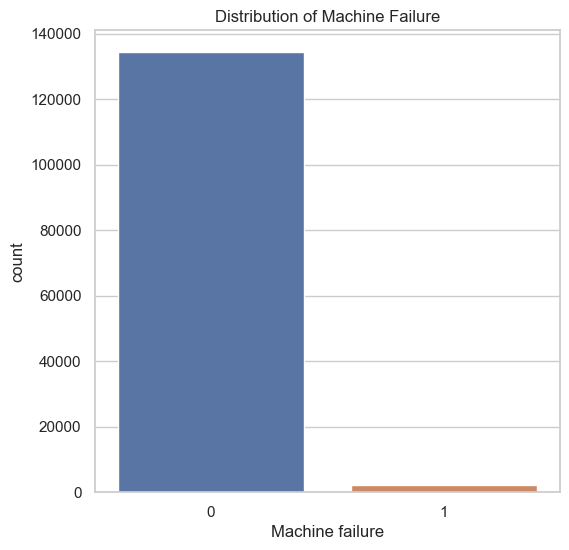

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn plot
sns.set(style="whitegrid")

# Checking the balance of the target variable
plt.figure(figsize=(6, 6))
sns.countplot(x='Machine failure', data=data)
plt.title('Distribution of Machine Failure')
plt.show()


It appears that we have an imbalanced dataset, with many more instances of no machine failure (Machine failure = 0) than of machine failure (Machine failure = 1). This is important to keep in mind as we proceed, as it may influence how we choose to train and evaluate our predictive model.

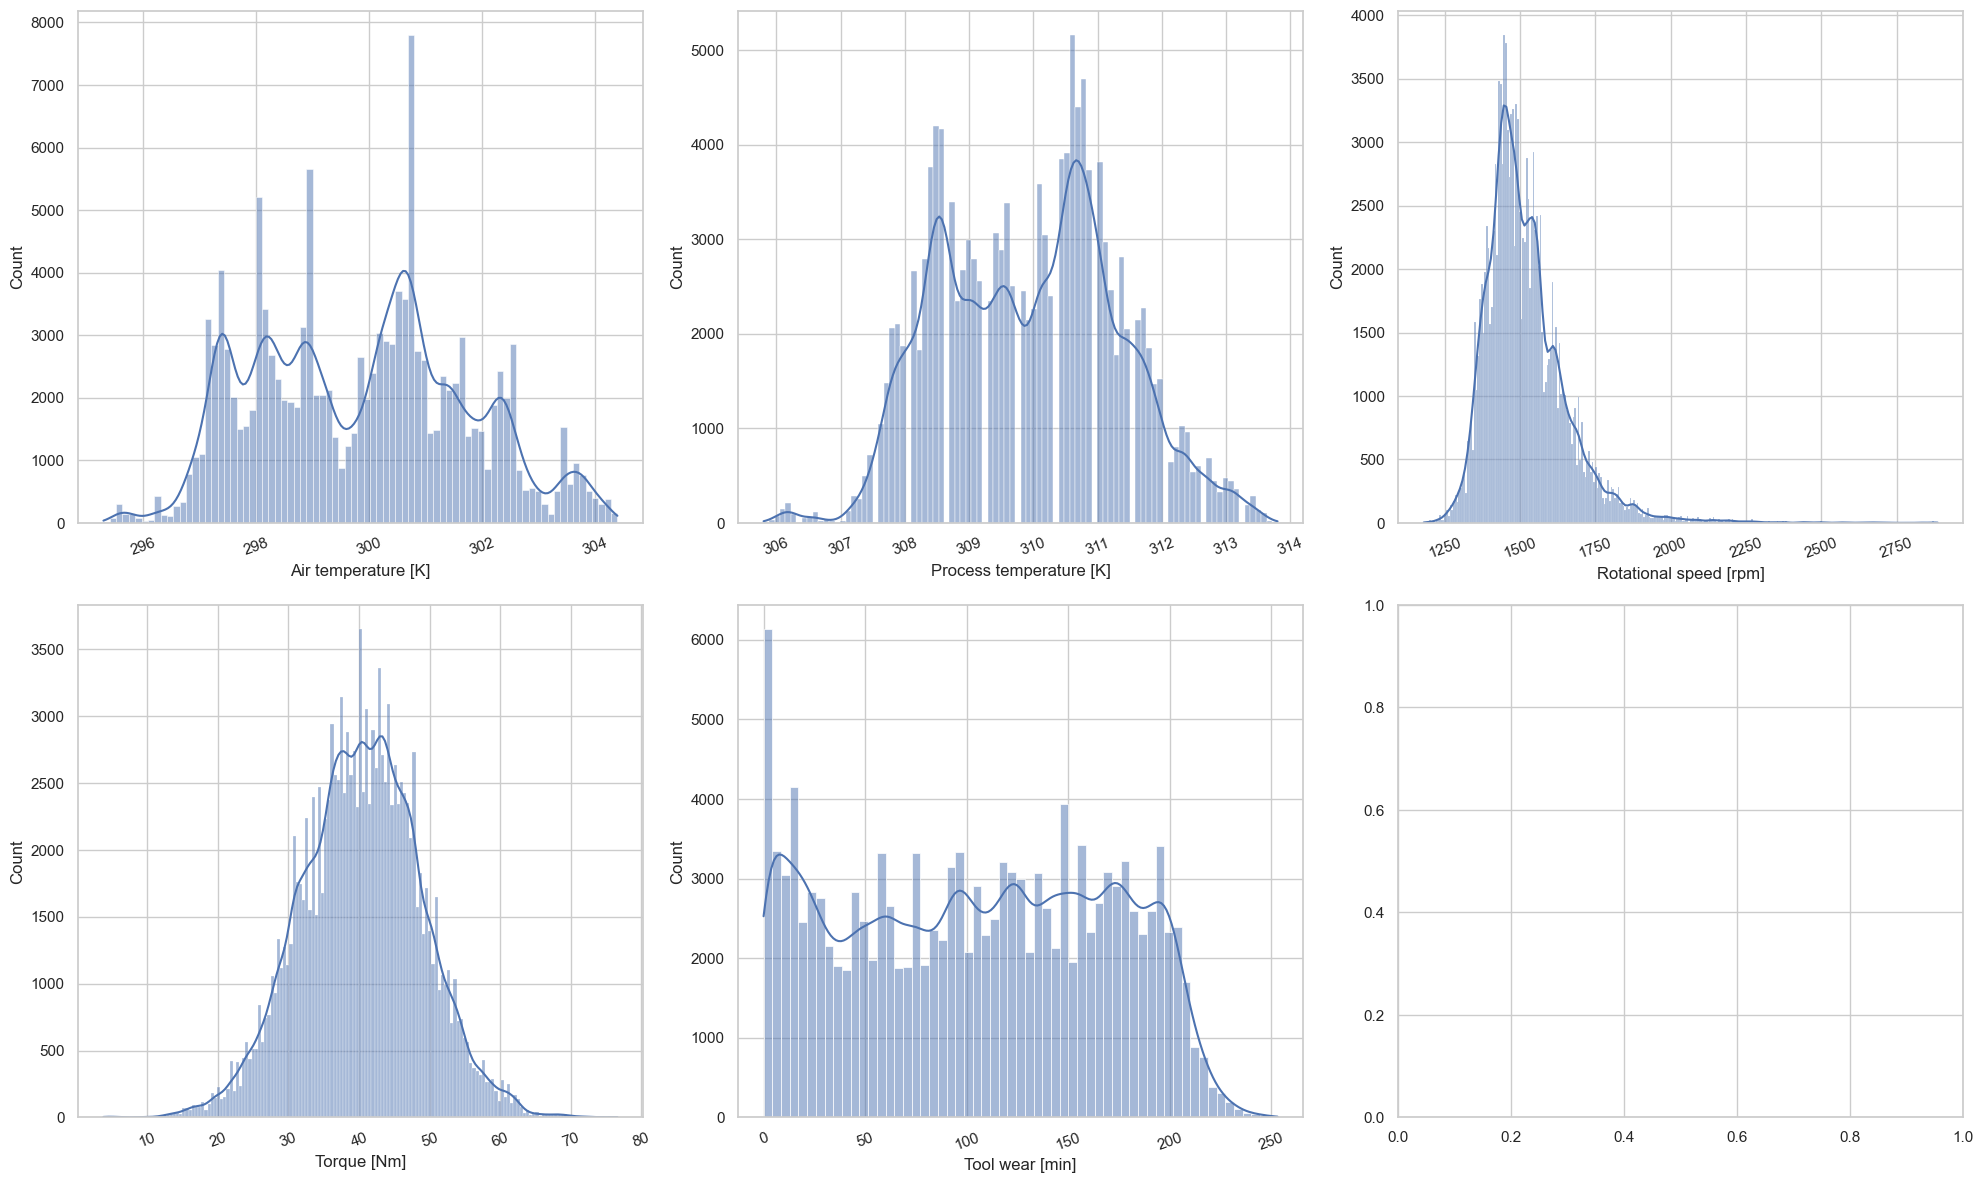

In [4]:
# Numeric columns
numeric_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                'Torque [Nm]', 'Tool wear [min]']

# Distribution of the numeric variables
fig, ax = plt.subplots(2, 3, figsize=(20, 12))

for variable, subplot in zip(numeric_cols, ax.flatten()):
    sns.histplot(data[variable], ax=subplot, kde=True)
    for label in subplot.get_xticklabels():
        label.set_rotation(20)

plt.tight_layout()
plt.show()


Air temperature [K] and Process temperature [K]: These variables appear to be normally distributed, with most values centered around 300K and 310K respectively.
Rotational speed [rpm]: This variable shows a near normal distribution, with a peak around 1550 rpm.
Torque [Nm]: This variable has a distribution with two peaks, suggesting a bimodal distribution.
Tool wear [min]: This variable shows a somewhat uniform distribution until approximately 200 minutes, after which the frequency of instances decreases significantly.

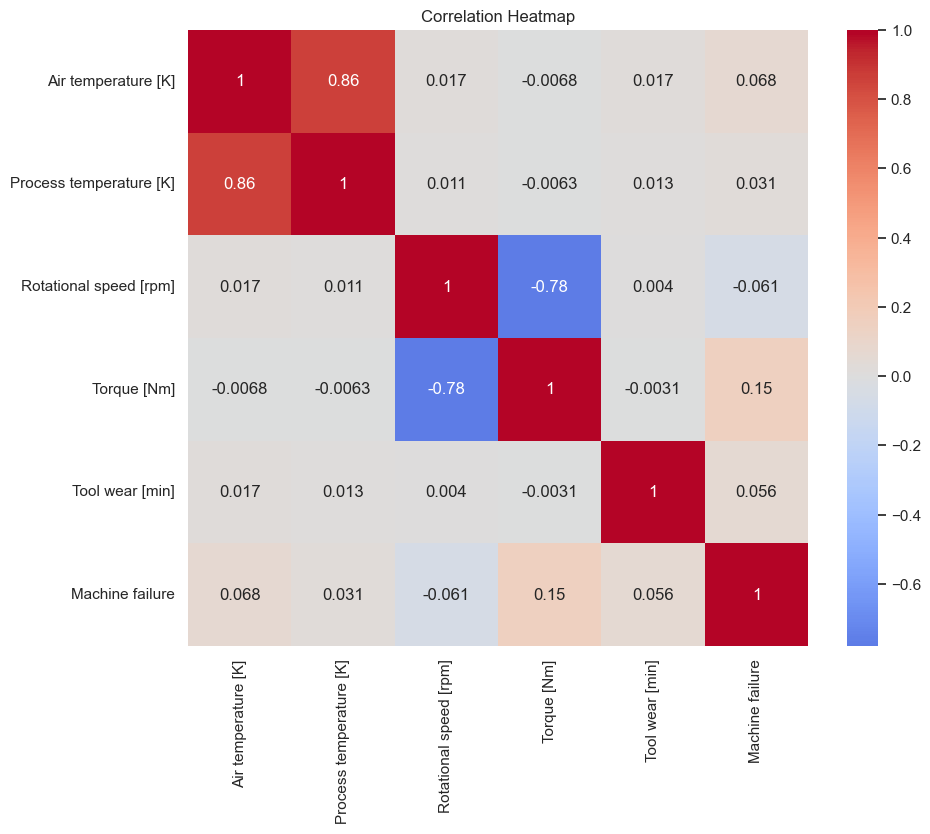

In [5]:
# Calculate correlations
correlations = data[numeric_cols + ['Machine failure']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


Machine failure has a relatively strong positive correlation with Tool wear [min] and Torque [Nm]. This suggests that as tool wear and torque increase, the likelihood of machine failure also increases.


Machine failure also has a slight negative correlation with Air temperature [K] and Rotational speed [rpm]. This suggests that lower air temperature and rotational speed might be associated with an increased likelihood of machine failure, although these relationships are weaker.


Among the numeric variables, Torque [Nm] and Rotational speed [rpm] show a strong negative correlation. This is logical, as higher speeds can often result in lower torque, and vice versa.

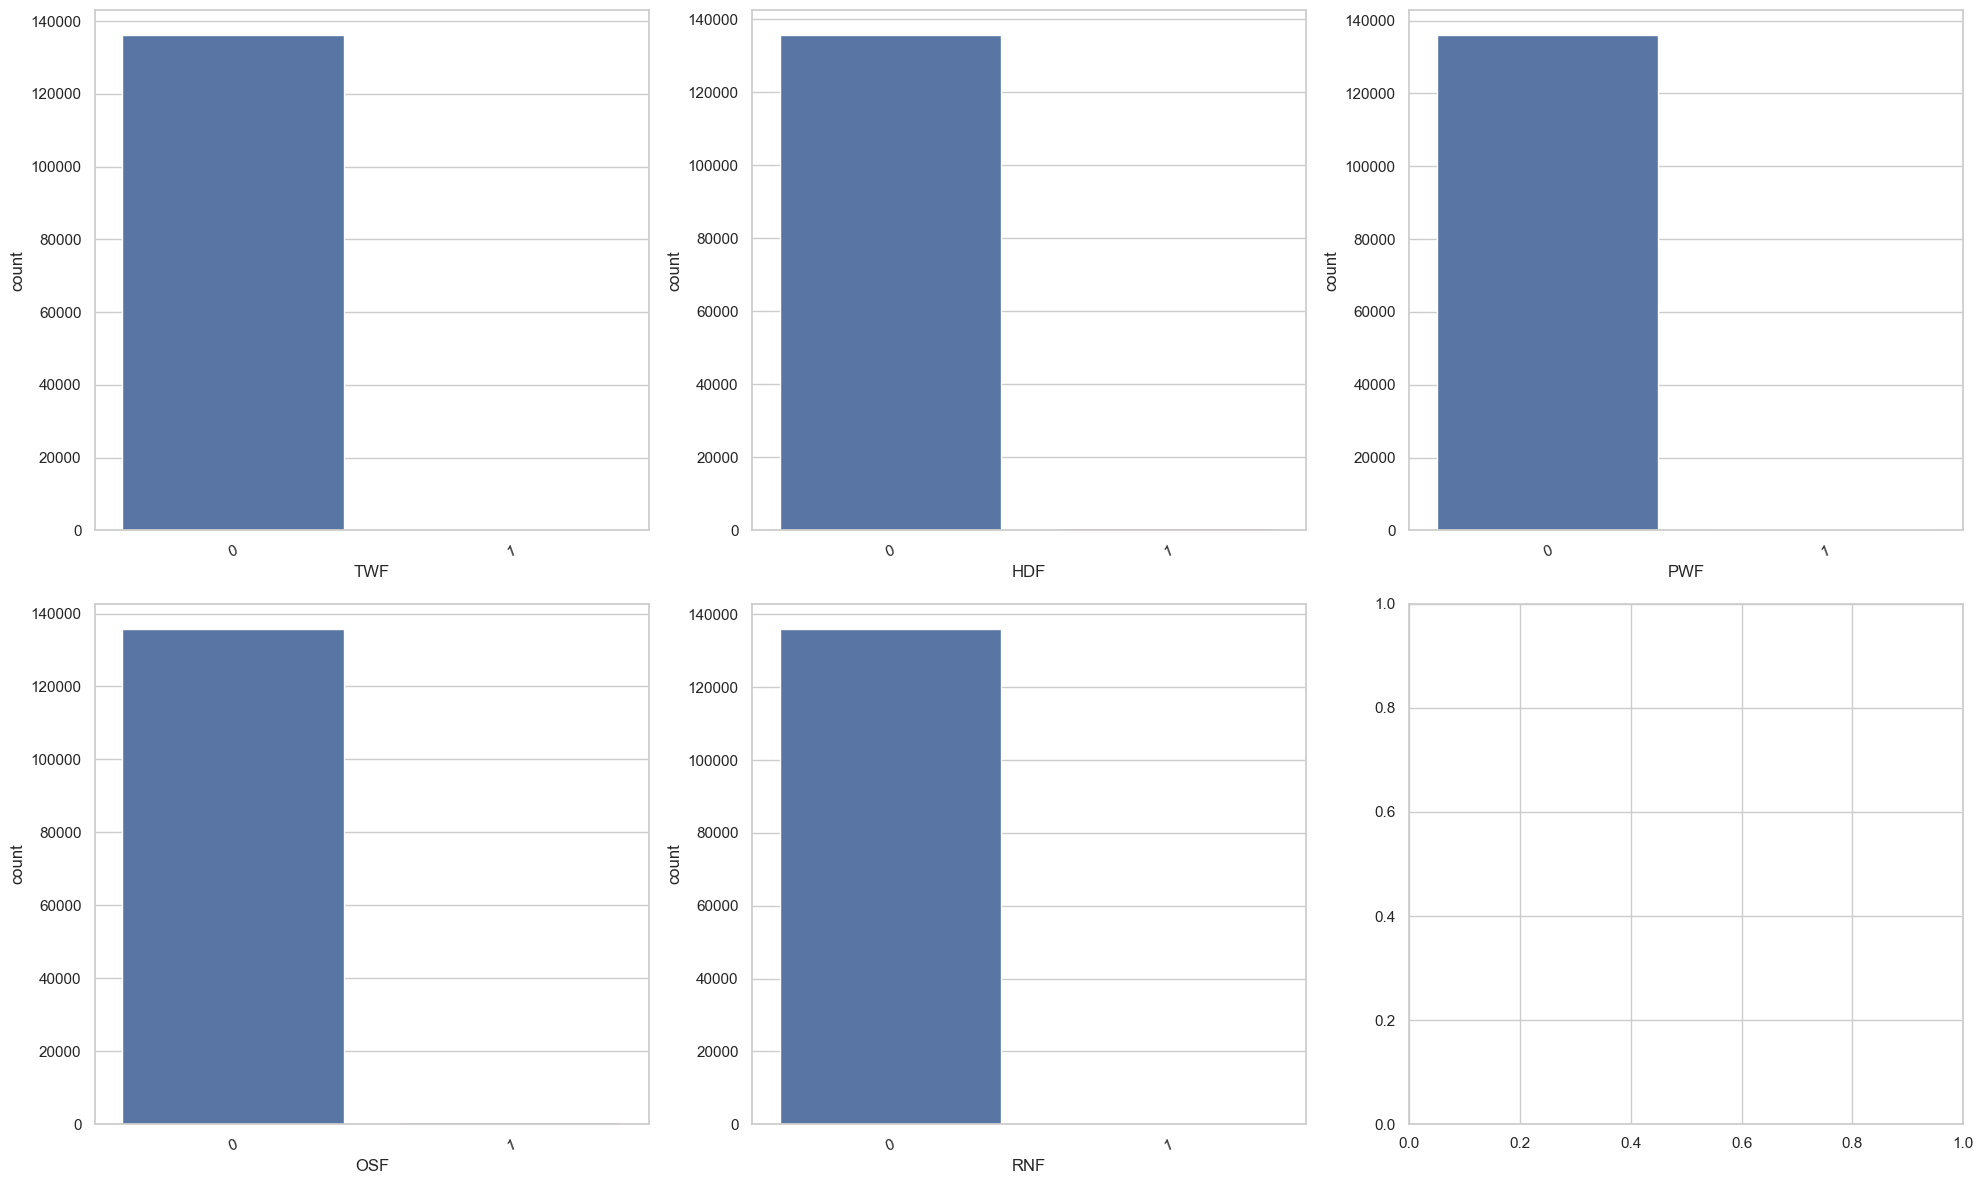

In [6]:
# Failure types
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Plotting the distribution of failure types
fig, ax = plt.subplots(2, 3, figsize=(20, 12))

for failure_type, subplot in zip(failure_types, ax.flatten()):
    sns.countplot(x=failure_type, data=data, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(20)

plt.tight_layout()
plt.show()


TWF (Tool Wear Failure), HDF (Heat Dissipation Failure), PWF (Power Failure), OSF (Overstrain Failure), and RNF (Random Failure): These variables are binary, indicating the occurrence or absence of a particular type of failure. For all types, failure events are much less common than non-failure events, indicating that these are relatively rare events.

# Model Building

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Drop unnecessary columns
data = data.drop(['id', 'Product ID'], axis=1)

# Encoding the categorical variables
le = LabelEncoder()
data['Type'] = le.fit_transform(data['Type'])

# Defining the features (X) and the target (y)
X = data.drop('Machine failure', axis=1)
y = data['Machine failure']

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardizing the numeric features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])

X_train.head()


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
72862,2,-1.429471,-1.111226,-0.161928,-0.416861,-0.054797,0,0,0,0,0
81454,2,-0.355489,-1.111226,-1.027237,0.959733,1.415468,0,0,0,0,0
134753,1,1.362882,0.764097,-1.005604,1.171516,1.540597,0,0,0,0,0
60614,1,-0.731383,-0.389948,0.184196,-0.510988,1.024440,0,0,0,0,0
92513,1,0.074103,1.052608,-0.421521,0.712652,1.290339,0,0,0,0,0


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Create a Random Forest classifier with class weights to handle imbalanced data
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict the probabilities of machine failure on the validation set
y_val_proba = clf.predict_proba(X_val)[:, 1]

# Calculate the AUC-ROC
roc_auc = roc_auc_score(y_val, y_val_proba)
roc_auc


0.9340031849450298

The Area Under the Receiver Operating Characteristic Curve (AUC-ROC) for our Random Forest classifier on the validation set is approximately 0.934. This is a relatively good score, as an AUC-ROC of 1 represents a perfect classifier, while an AUC-ROC of 0.5 represents a random classifier.

In [10]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model with class weights to handle imbalanced data
log_reg = LogisticRegression(class_weight='balanced', random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Predict the probabilities of machine failure on the validation set
y_val_proba_logreg = log_reg.predict_proba(X_val)[:, 1]

# Calculate the AUC-ROC
roc_auc_logreg = roc_auc_score(y_val, y_val_proba_logreg)
roc_auc_logreg


0.9293554426363517

The AUC-ROC score for the logistic regression model on the validation set is approximately 0.929. This score is slightly lower than the one obtained using the Random Forest classifier (0.934), but it's still quite good.

In [11]:
# Get the coefficients of the logistic regression model
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': log_reg.coef_[0]})

# Sort by the absolute value of the coefficient
coefficients['abs'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('abs', ascending=False).drop('abs', axis=1)

coefficients


,Feature,Coefficient
8,PWF,9.331962
6,TWF,8.232570
7,HDF,8.211513
9,OSF,7.674090
4,Torque [Nm],1.097954
1,Air temperature [K],0.616743
3,Rotational speed [rpm],0.594256
2,Process temperature [K],-0.396808
5,Tool wear [min],0.318792
10,RNF,0.303122


**PWF (Power Failure)**, **TWF (Tool Wear Failure)**, **HDF (Heat Dissipation Failure)**, **OSF (Overstrain Failure)**: These variables have the largest positive coefficients, indicating that they significantly increase the predicted probability of machine failure.

**Torque [Nm] (Torque)**, **Air temperature [K] (Air Temperature)**, **Rotational speed [rpm] (Rotational Speed)**: These variables also have positive coefficients, indicating that they increase the predicted probability of machine failure, but to a lesser extent.

**Process temperature [K] (Process Temperature)**, **Type**: These variables have negative coefficients, indicating that they decrease the predicted probability of machine failure.
**Tool wear [min] (Tool Wear)**, **RNF (Random Failure)**: These variables have smaller positive coefficients, indicating that they have a smaller impact on the predicted probability of machine failure.

**Stacking Models**

In [12]:
from sklearn.ensemble import StackingClassifier

# Define the base models
base_models = [('Random Forest', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
               ('Logistic Regression', LogisticRegression(class_weight='balanced', random_state=42))]

# Create the stacking model
stack_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), cv=5)

# Train the stacking model
stack_model.fit(X_train, y_train)

# Predict the probabilities of machine failure on the validation set
y_val_proba_stack = stack_model.predict_proba(X_val)[:, 1]

# Calculate the AUC-ROC
roc_auc_stack = roc_auc_score(y_val, y_val_proba_stack)
roc_auc_stack


C:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

0.9390165291546301

The AUC-ROC score for the stacked model on the validation set is approximately 0.939. This is an improvement compared to both the Random Forest model (AUC-ROC = 0.934) and the Logistic Regression model (AUC-ROC = 0.929). Lets try XGboost as well.

In [16]:
from xgboost import XGBClassifier
# Create a XGBoost model with default hyperparameters
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=sum(y_train==0)/sum(y_train==1), use_label_encoder=False, eval_metric='logloss')

X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_val.columns]

# Train the model
xgb_model.fit(X_train, y_train)

# Predict the probabilities of machine failure on the validation set
y_val_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Calculate the AUC-ROC
roc_auc_xgb = roc_auc_score(y_val, y_val_proba_xgb)
roc_auc_xgb


0.9521968154013482

In [18]:
# Load the test data
test_data = pd.read_csv('test.csv')

# Drop unnecessary columns
test_data = test_data.drop(['id', 'Product ID'], axis=1)

# Encoding the categorical variables
test_data['Type'] = le.transform(test_data['Type'])
# Correcting column names in test data
test_data.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test_data.columns]

# Predict the probabilities of machine failure on the test set
y_test_proba_xgb = xgb_model.predict_proba(test_data)[:, 1]

y_test_proba_xgb


array([0.98890966, 0.98890966, 0.98890966, ..., 0.98890966, 0.98890966,
       0.98890966], dtype=float32)

In [20]:
# Load the test data again to get the 'id' column
test_data_original = pd.read_csv('test.csv')

# Create a dataframe for the predictions
predictions = pd.DataFrame({'id': test_data_original['id'], 'Machine failure': y_test_proba_xgb})

# Save the predictions to a csv file
predictions.to_csv('predictions.csv', index=False)

predictions.head()


,id,Machine failure
0,136429,0.988910
1,136430,0.988910
2,136431,0.988910
3,136432,0.982789
4,136433,0.982789
